In [1]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importamos librerias de scikit learn para clasificacion y modelos de SVM.
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [3]:
# importamos librearias de Logistic Regression
from sklearn.linear_model import LogisticRegression

In [4]:
#Importamos librerias de Feature Selection
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from sklearn.feature_selection import VarianceThreshold

In [5]:
# Importamos librerias de PCA
from sklearn.decomposition import PCA

In [6]:
pwd

'C:\\Users\\60065215\\Desktop\\Facultad\\Ciencia de Datos\\clase_06'

# Importamos dataset de Wisconsin Breast Cancer

In [7]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
x = data.data
y = data.target

In [8]:
x.shape

(569, 30)

In [9]:
y.shape

(569,)

In [10]:
np.unique(y)

array([0, 1])

# Separamos nuestros datos en Train y Test

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=4)

# Realizamos Auto Scaling

In [12]:
# Step 4: auto scaling train- set (mean = 0, std = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(xtrain)
scaler

StandardScaler()

In [13]:
xtrain_scal = scaler.transform(xtrain)  
xtest_scal = scaler.transform(xtest)  

In [14]:
#Voy a ver que tiene el 70% de las muestras que es lo que indique cuando hice train_test_split
xtrain_scal.shape

(398, 30)

# Analisis de Componentes Principales (PCA)
Vamos a obtener primeros 10 autovalores y autovectores (eigenvalues y eigenvectors) de la matriz de train "xtrain_scal". 

In [15]:
from sklearn.decomposition import PCA
# cantidad de componentes a extraer
n_comps = 10
# definimos PCA
pca = PCA(n_components= n_comps)
# fit_transform del PCA a nuestros datos
xpca = pd.DataFrame(pca.fit_transform(xtrain_scal))
# obtenemos los auto-valores
eigenvalues = pca.explained_variance_ratio_
eigenvalues

array([0.44604183, 0.18260156, 0.10040269, 0.06410772, 0.05566709,
       0.04241754, 0.02164451, 0.0159364 , 0.01278413, 0.01074278])

In [16]:
# observamos el shape de la matriz obtenida del PCA. Ver que nuestro dataset se redujo de 30 a 10 dimensiones
xpca.shape

(398, 10)

# Observamos los autovalores obtenidos del PCA
Recordemos que los autovalores significa la variabilidad que "atrapa" cada componente principal. Obviamente siempre vamos a priorizar las componentes principales que mayor variabilidad capten de los datos de entrenamiento.

In [17]:
components = range(1,n_comps + 1)
components

range(1, 11)

In [18]:
type(components)

range

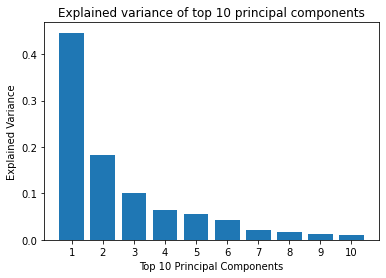

In [19]:
plt.bar(components,eigenvalues)
plt.xticks(components)
plt.title('Explained variance of top ' +  str(n_comps) + ' principal components')
plt.xlabel('Top ' +  str(n_comps) + ' Principal Components')
plt.ylabel('Explained Variance')
plt.show()

# Scatter plot del PCA
Con las 2 primeras componentes principales **antes** de la selección de variables visualizamos nuestras muestras/samples de train. **Atencion!** vean que estamos visualizando datos de 30 dimensiones en solamente 2 :). Otro punto importante es que con las dos primeras componentes principales captamos el 65 % aprox de la variabilidad de mis datos (hacer explained variance de PC1 + PC2)

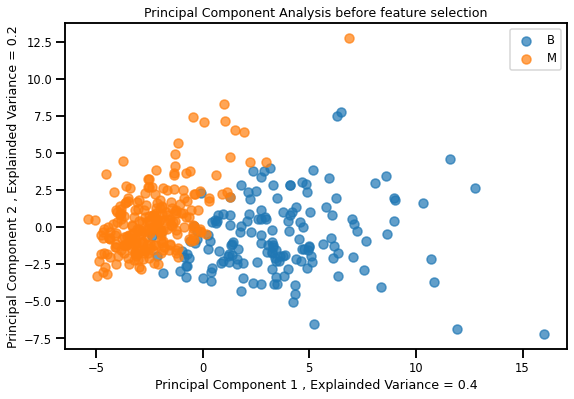

In [20]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(9,6))
plt.scatter(xpca.loc[(ytrain == 0).ravel(),0],xpca.loc[(ytrain == 0).ravel(),1], alpha = 0.7, label = 'B')
plt.scatter(xpca.loc[(ytrain == 1).ravel(),0],xpca.loc[(ytrain == 1).ravel(),1], alpha = 0.7, label = 'M')
plt.xlabel('Principal Component 1 , Explainded Variance = ' + str(np.round(eigenvalues[0],1)))
plt.ylabel('Principal Component 2 , Explainded Variance = ' + str(np.round(eigenvalues[1],1)))
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

In [21]:
pepe = xpca.loc[(ytrain == 0),9] #Lo que hace en esta línea es filtrar las etiquetas de la feature "9" que sean 0. En el grafico de arriba lo hace pero muestra las componentes princiapales (no la novena) es decir la 0 y 1.
pepe

0     -2.107259
1      0.836230
2      0.022752
9      0.367548
11     1.370450
         ...   
384   -0.835096
386    0.057002
388   -0.227269
392    0.202700
397    0.264472
Name: 9, Length: 158, dtype: float64

Estamos visualizando datos de alta dimension en 2 dimensiones :):):):). Ojo que con las dos primeras componentes visualizamos el 63% de la variabilidad del dataset original. Es decir que sirve para darnos una idea aunque lo que se aconseja es quedarse con las componentes que acumulan aunque sea el 80% de la variabilidad original.

In [22]:
# vamos a visualizar en 3d
from mpl_toolkits.mplot3d import Axes3D

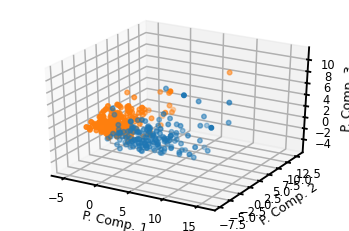

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xpca.iloc[(ytrain == 0).ravel(),0], xpca.iloc[(ytrain == 0).ravel(),1], xpca.iloc[(ytrain == 0).ravel(),2])
ax.scatter(xpca.iloc[(ytrain == 1).ravel(),0], xpca.iloc[(ytrain == 1).ravel(),1], xpca.iloc[(ytrain == 1).ravel(),2])
ax.set_xlabel('P. Comp. 1')
ax.set_ylabel('P. Comp. 2')
ax.set_zlabel('P. Comp. 3')
plt.show()

# kernel-PCA

Computamos el desvio standard de cada feature. Luego decidimos quedarnos con aquellas cuyo STDEV sea mayor a un cuantil determinado. Eso resultara de un vector "mascara" booleano que nos serirá para filtrar el dataset original. Vean que este metodo es no supervisado aunque su debilidad es que es univariado.

In [24]:
from sklearn.decomposition import PCA, KernelPCA

In [25]:
# cantidad de componentes a extraer
n_comps = 10
# definimos PCA
kpca = KernelPCA(n_components= n_comps, kernel = 'rbf', gamma = 0.14)
# fit_transform del PCA a nuestros datos
xkpca = pd.DataFrame(kpca.fit_transform(xtrain_scal))


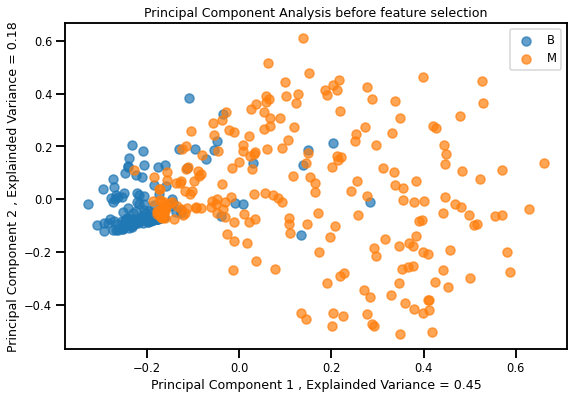

In [26]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(9,6))
plt.scatter(xkpca.loc[(ytrain == 0).ravel(),0],xkpca.loc[(ytrain == 0).ravel(),1], alpha = 0.7, label = 'B')
plt.scatter(xkpca.loc[(ytrain == 1).ravel(),0],xkpca.loc[(ytrain == 1).ravel(),1], alpha = 0.7, label = 'M')
plt.xlabel('Principal Component 1 , Explainded Variance = ' + str(np.round(eigenvalues[0],2)))
plt.ylabel('Principal Component 2 , Explainded Variance = ' + str(np.round(eigenvalues[1],2)))
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

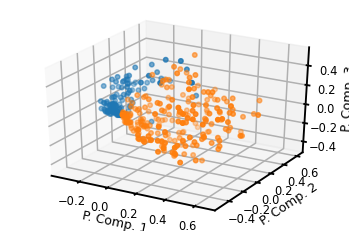

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xkpca.iloc[(ytrain == 0).ravel(),0], xkpca.iloc[(ytrain == 0).ravel(),1], xkpca.iloc[(ytrain == 0).ravel(),2])
ax.scatter(xkpca.iloc[(ytrain == 1).ravel(),0], xkpca.iloc[(ytrain == 1).ravel(),1], xkpca.iloc[(ytrain == 1).ravel(),2])
ax.set_xlabel('P. Comp. 1')
ax.set_ylabel('P. Comp. 2')
ax.set_zlabel('P. Comp. 3')
plt.show()

# Asignacion 01:
Partiendo de los datos originales crear un nuevo train-test split donde train es el 10% de los datos. Reducir la dimension con PCA y kPCA. Clasificar usando las proyecciones obtenidas con logistic regression. Medir la calidad de la clasificacion en area debajo de la curva y accuracy.

## Creo un nuevo train-test split con train = 10%

In [28]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.9, random_state=0)

In [29]:
print('Ahora mi Xtrain tiene: ' + str(xtrain.shape[0]) + ' samples')

Ahora mi Xtrain tiene: 56 samples


## Realizamos el Auto Scaling con mis nuevas muestras de train

In [30]:
# Auto scaling train- set (mean = 0, std = 1)
scaler2 = StandardScaler().fit(xtrain)
scaler2

StandardScaler()

In [31]:
xtrain_scal2 = scaler.transform(xtrain)  
xtest_scal2 = scaler.transform(xtest)  

## En primera instancia trabajamos con PCA
Vamos a obtener primeros 10 autovalores y autovectores (eigenvalues y eigenvectors) de la matriz de train "xtrain_scal2". 

In [32]:
#from sklearn.decomposition import PCA
# cantidad de componentes a extraer
n_com = 10
# definimos PCA
pca2 = PCA(n_components= n_com)
# fit_transform del PCA a nuestros datos
zpca2_train = pd.DataFrame(pca2.fit_transform(xtrain_scal2))
# obtenemos los auto-valores
eigenvalues_train = pca2.explained_variance_ratio_
print('Los autovalores de xtrain_scal2 obtenidos al aplicar PCA son: ')
eigenvalues_train

Los autovalores de xtrain_scal2 obtenidos al aplicar PCA son: 


array([0.41577233, 0.21743963, 0.09195273, 0.07106787, 0.05351418,
       0.04652583, 0.02723071, 0.02127044, 0.01305474, 0.01063696])

In [33]:
# fit_transform del PCA a nuestros datos de test
zpca2_test = pd.DataFrame(pca2.fit_transform(xtest_scal2))
# obtenemos los auto-valores
eigenvalues_test = pca2.explained_variance_ratio_
print('Los autovalores de xtest_scal2 obtenidos al aplicar PCA son: ')
eigenvalues_test

Los autovalores de xtest_scal2 obtenidos al aplicar PCA son: 


array([0.44728143, 0.18747977, 0.0947425 , 0.06708844, 0.05452839,
       0.04038331, 0.02137992, 0.0153346 , 0.01360135, 0.0109112 ])

##### Hasta aca lo único que se hizo fue la reducción de la dimensionalidad, trabajando las variables en un nuevo subespacio Z que pasó de 30 a 10 dimensiones.

## Logistic Regression
Se utiliza Logistic Regression para realizar la clasificación.

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
zpca2_train.shape

(56, 10)

In [36]:
logisticRegr_pca = LogisticRegression(solver = 'lbfgs')
logisticRegr_pca.fit(zpca2_train, ytrain)

LogisticRegression()

Con el modelo fiteado voy a utilizar las muestras de test (ya en mi subespacio Z) para evaluar la clasificación.

In [37]:
ypred_pca = logisticRegr_pca.predict(zpca2_test)

## Mido la calidad de la clasificación
Con el área debajo de la curva y el accuracy mido la calidad de la clasificación entrenada con logistic regression.

#### Calculo el Accuracy de dos formas distintas y verifico que da igual. En el primer caso uso ytest e ypred y en el segundo pasándole xtest e ytest


In [38]:
# Con accuracy_score calculo el accuracy entre las verdaderas etiquetas y las etiquetas estimadas
accuracy_lr_pca = accuracy_score(ytest, ypred_pca)
accuracy_lr_pca

0.9181286549707602

In [39]:
score_pca= logisticRegr_pca.score(zpca2_test, ytest)
score_pca

0.9181286549707602

Calculo y grafico el área bajo la curva.

In [40]:
# Ahora calculo la calidad con el área bajo la curva
ypred_proba = logisticRegr_pca.predict_proba(zpca2_test)
ypred_proba

array([[0.96164303, 0.03835697],
       [0.00563268, 0.99436732],
       [0.01515424, 0.98484576],
       ...,
       [0.54718262, 0.45281738],
       [0.42788138, 0.57211862],
       [0.04627676, 0.95372324]])

In [41]:
fpr1, tpr1, thresholds = roc_curve(ytest.astype('int'), ypred_proba[:,1], drop_intermediate = False)
auc = metrics.auc(fpr1, tpr1)
print("El AUC es = " + str(auc))

El AUC es = 0.9745579213280403


## Kernel PCA
Vamos a obtener primeros 10 autovalores y autovectores (eigenvalues y eigenvectors) de la matriz de train "xtrain_scal2". 

In [76]:
# definimos PCA
kpca2 = KernelPCA(n_components= n_com, kernel = 'rbf', gamma = 0.01)
# fit_transform del KPCA a nuestros datos
zkpca2_train = pd.DataFrame(kpca2.fit_transform(xtrain_scal2))

In [77]:
# fit_transform del KPCA a nuestros datos de test
zkpca2_test = pd.DataFrame(kpca2.fit_transform(xtest_scal2))

##### Hasta aca lo único que se hizo fue la reducción de la dimensionalidad, trabajando las variables en un nuevo subespacio Z que pasó de 30 a 10 dimensiones.

## Logistic Regression
Se utiliza Logistic Regression para realizar la clasificación.

In [78]:
zkpca2_train.shape

(56, 10)

In [79]:
logisticRegr_kpca = LogisticRegression(solver = 'lbfgs')
logisticRegr_kpca.fit(zkpca2_train, ytrain)

LogisticRegression()

Con el modelo fiteado voy a utilizar las muestras de test (ya en mi subespacio Z) para evaluar la clasificación.

In [80]:
ypred_kpca = logisticRegr_kpca.predict(zkpca2_test)

## Mido la calidad de la clasificación
Con el área debajo de la curva y el accuracy mido la calidad de la clasificación entrenada con logistic regression.

#### Calculo el Accuracy de dos formas distintas y verifico que da igual. En el primer caso uso ytest e ypred y en el segundo pasándole xtest e ytest


In [81]:
# Con accuracy_score calculo el accuracy entre las verdaderas etiquetas y las etiquetas estimadas
accuracy_lr_kpca = accuracy_score(ytest, ypred_kpca)
accuracy_lr_kpca

0.9317738791423001

Calculo y grafico el área bajo la curva.

In [82]:
# Ahora calculo la calidad con el área bajo la curva
ypred_probak = logisticRegr_pca.predict_proba(zkpca2_test)
ypred_probak

array([[0.59898355, 0.40101645],
       [0.42343644, 0.57656356],
       [0.36517863, 0.63482137],
       ...,
       [0.50415562, 0.49584438],
       [0.46619977, 0.53380023],
       [0.41491124, 0.58508876]])

In [83]:
fpr2, tpr2, thresholds = roc_curve(ytest.astype('int'), ypred_probak[:,1], drop_intermediate = False)
auc2 = metrics.auc(fpr2, tpr2)
print("El AUC de la clasificación utilizando KPCA es = " + str(auc2))

El AUC de la clasificación utilizando KPCA es = 0.978921295233096
